In [1]:
import pyslim, tskit, msprime
from IPython.display import SVG
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import util

```{eval-rst}
.. currentmodule:: pyslim
```

(sec_vignette_coalescent_diversity)=

# Vignette: Starting with diversity generated by coalescent simulation

This vignette shows how to simulate history with msprime,
add SLiM mutations to it and assign them selection coefficients,
then run a SLiM simulation using this as a starting point.

Simulations of large populations with selection can be costly,
especially if we need to run a lengthy "burn-in" period to get the
genetic diversity for selection to act on.
Sometimes, the precise form of the burn-in is not important,
and so a *neutral* burn-in is acceptable - allowing us to use msprime.
For instance, suppose we'd like to simulate a lab experiment
in which we take high-diversity organisms from the wild and subject them
to selection for a few dozen generations.
Genetic diversity in the wild is certainly not neutral, but then again,
we don't quite know what it *does* look like, so a coalescent simulation
would be better than nothing. The key attribute of reality we'd like to
approximate is the joint distribution of allele frequencies and effect
sizes. If the alleles affect a trait under stabilizing selection, we'd
expect a negative correlation between the two. On the other hand,
if the trait we're selecting on in the lab is not under strong selection
in the wild, there might not be much of a relationship.
This is a simple example, to show how to do this:
the trait under selection is just fitness,
and there is no relationship between allele frequency and effect size.

The steps will be:

1. Run a coalescent simulation with msprime.
2. Add SLiM metadata to the nodes, individuals, and populations.
3. Add SLiM mutations with msprime,
   and edit the mutation metadata to assign selection coefficients.
4. Run the SLiM portion of the simulation.
5. Do some descriptive analysis of the results of selection.
6. Add neutral mutations to the tree sequence.
7. Do some descriptive analysis of genetic diversity along the genome.


## Mutation and recombination maps

In this model,
we'll also demonstrate how to modulate the mutation and recombination rate
along the genome. We'll do a simple example: a 9MB genome
with three equally-sized domains.
The first and last third of the genome will have high recombination
(5e-8 per generation per bp),
and the middle third will have low recombination
(0.5e-8 per generation per bp).
The mutation rate will be constant (3e-8 per generation per bp),
but a lower proportion of mutations in the middle region are under selection:
on the outside thirds, 1% of mutations are beneficial with a selection coefficient
drawn from an Exponential distribution,
and in the middle third, only 0.1% are (but with the same distribution of selection coefficients).
This implies that the mutation rate *of beneficial mutations* on the ends
is {math}`0.01 \times 30^{-8}` = 3e-10, and in the middle is 3e-11.
We'll simulate these first, and only add the neutral mutations after everything else,
at rates 2.97e-8 on the ends, and 2.997e-8 in the middle.


## The coalescent simulation

First, we'll use msprime
to simulate the demographic history of 2,000 smallish chromosomes
({math}`N_e = 1,0000` diploids)
from a population of 10,000 diploids total.

In [2]:
breaks = [0, 3000000, 6000000, 9000000]
recomb_map = msprime.RateMap(
  position = breaks,
  rate = [5e-8, 0.5e-8, 5e-8])
demog_model = msprime.Demography()
demog_model.add_population(initial_size=10000)
ots = msprime.sim_ancestry(
        samples=1000,
        demography=demog_model,
        random_seed=5,
        recombination_rate=recomb_map)

## Annotate everyone

At this point, we have genealogical information: individuals,
nodes (chromosomes), and relationships between them,
but no genetic diversity; no mutations.
First, we'll add SLiM metadata to all of these things,
a procedure we call "annotating".

In [3]:
ots = pyslim.annotate(ots, model_type="WF", tick=1, stage="late")

This method adds default metadata to everything that needs it:
in this case, all individuals, all nodes that are part of alive individuals,
and all populations referenced by nodes.
These default values are returned by {func}`.slim_default_metadata`
(e.g., all individuals are hermaphrodite, all chromosomes are autosomal);
see {func}`.annotate` for more information.

## Add SLiM mutations

Next, we're going to use the {class}`msprime.SLiMMutationModel` to add mutations
to the tree sequence. These will carry SLiM metadata, but this metadata
will say that the mutations are neutral. So, we'll then need to modify their metadata
after the fact to have selection coefficients drawn from some distribution.
(Remember, our motivation here is that we are using msprime to obtain
a plausible level of functional standing genetic variation
on which selection can act:
imagine that the mutations were (nearly) neutral in the wild,
but then became subject to strong selection in the lab, for some reason.)
We'll want this to be as if we'd done it in a burn-in script in SLiM:

```
   initialize() {
      ...
      initializeMutationType("m2", 0.5, "e", 0.04);
      initializeMutationRate(3e-10);
   }

   fitness(m2) {
       return 1.0;
   }
```

In other words, we'd like to pull selection coefficients from an exponential distribution
with mean 0.04 (but, of course, this is a coalescent simulation, so the
dynamics of the mutations up until this point have been neutral).
Note that the dominance coefficient is *not* stored in the tree sequence:
it gets set in the SLiM recipe
because it's a property of the mutation type, not of individual mutations, in SLiM.
Here's how to add SLiM mutations with msprime:

In [4]:
mut_map = msprime.RateMap(
           position=breaks,
           rate=[0.03e-8, 0.003e-8, 0.03e-8])
mut_model = msprime.SLiMMutationModel(type=2)
ots = msprime.sim_mutations(
            ots,
            rate=mut_map,
            model=mut_model,
            keep=True, 
            random_seed=12)
print(f"The tree sequence now has {ots.num_mutations} mutations, at "
      f"{ots.num_sites} distinct sites.")

The tree sequence now has 609 mutations, at 609 distinct sites.


Note the ``type=2`` argument to {class}`msprime.SLiMMutationModel`:
this means the mutations will be of type "m2" in SLiM (and, so you must
initialize that mutation type in the recipe that loads this tree sequence in).

Now, we'll assign selection coefficients.
Recall that to accomodate mutation stacking in SLiM,
a mutation metadata entry is in fact a *list* of metadata entries,
one for each of the SLiM mutations that are stacked at this position.
The SLiM IDs of these mutations are available (in the same order)
as a comma-separated list of integers in the derived state of the mutation.
So, in case some SLiM mutations appear in more than one mutation
in the tree sequence, we will build a map from SLiM ID to selection coefficient:
``mut_map[k]`` will give the selection coefficient of the SLiM mutation with
SLiM mutation ID ``k``.

In [5]:
rng = np.random.default_rng(seed=1234)
tables = ots.tables
tables.mutations.clear()
mut_map = {}
for m in ots.mutations():
  md_list = m.metadata["mutation_list"]
  slim_ids = m.derived_state.split(",")
  assert len(slim_ids) == len(md_list)
  for sid, md in zip(slim_ids, md_list):
     if sid not in mut_map:
        mut_map[sid] = rng.exponential(scale=0.04)
     md["selection_coeff"] = mut_map[sid]
  _ = tables.mutations.append(
          m.replace(metadata={"mutation_list": md_list})
  )

# check we didn't mess anything up
assert tables.mutations.num_rows == ots.num_mutations
print(f"The selection coefficients range from {min(mut_map.values()):0.2e}")
print(f"to {max(mut_map.values()):0.2e}.")

The selection coefficients range from 3.68e-06
to 3.51e-01.


## Load into SLiM

Before loading the tree sequence into SLiM, we should check the top-level metadata.
We can see this with ``tables.metadata``:

In [6]:
tables.metadata

{'SLiM': {'cycle': 1,
  'description': '',
  'file_version': '0.8',
  'model_type': 'WF',
  'name': '',
  'nucleotide_based': False,
  'separate_sexes': False,
  'spatial_dimensionality': '',
  'spatial_periodicity': '',
  'stage': 'late',
  'tick': 1}}

In [7]:
util.pp(tables.metadata)

{
 'SLiM': {
     'cycle': 1,
     'description': '',
     'file_version': '0.8',
     'model_type': 'WF',
     'name': '',
     'nucleotide_based': False,
     'separate_sexes': False,
     'spatial_dimensionality': '',
     'spatial_periodicity': '',
     'stage': 'late',
     'tick': 1
    }
}


We should edit this to match our planned slimulation
- particularly the ``model_type`` (WF or nonWF) and the ``tick``.
The ``tick`` tells SLiM what value to set the tick counter to
once this tree sequence is loaded. In principle, it can be set to anything,
independently of the times in the tree sequence,
because the times in the tree sequence are measured in units of
"time before the end"; and the ``tick`` that gets
passed to SLiM sets what that "end time" is, in SLiM's time.
However, if you change this, the ``slim_time`` attributes in mutation metadata
will not be accurate. This is harmless, unless you do something with mutations'
times yourself.

The ``model_type`` is already Wright-Fisher, but just to demonstrate how to
edit the metadata, let's make sure,
and then we'll write the tree sequence to a file.

In [8]:
ts_metadata = tables.metadata
ts_metadata["SLiM"]["model_type"] = "WF"
tables.metadata = ts_metadata
ots = tables.tree_sequence()
ots.dump("vignette_annotated.init.trees")

Now for the SLiM recipe.
This simply continues selected mutations as before
(with mutation rate 1e-10 per bp per generation
and the same distribution of fitness effects).
The population size is determined by the number of individuals that were
read in from the tree sequence.
We need to make sure that the genome lengths match,
so we provide that as a constant ``L``, that will be provided at run time.
To facilitate later analysis, we'll also "Remember" the individuals
present at the *start* of the simulation,
so that they will remain in the tree sequence.

```{literalinclude} reload_annotated.slim
```

Note that the simulation only has selected mutations (of type ``m2``),
but as we'll add in type ``m1`` mutations later,
we've declared them in the recipe as a placeholder.

We could run this on the command line as
``slim -d L=100000000 reload_annotated.slim``,
but this time we'll stay within python,
and obtain the sequence length programatically:

In [9]:
import subprocess
msg = subprocess.check_output(
     ["slim", "-d", f"L={int(ots.sequence_length - 1)}",
      "-s", "5", "reload_annotated.slim"])
print(msg.decode())

// Initial random seed:
5

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'WF');
initializeTreeSeq();
initializeMutationRate(c(3e-10, 3e-11, 3e-10), c(2999999, 5999999, 8999999));
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(2, 0.5, "e", 0.01);
initializeGenomicElementType(1, m2, 1);
initializeGenomicElement(g1, 0, 8999998);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 

Done.



This runs quickly, since it's only 100 generations.

## Analyze results

First, let's look at what mutations are present.

In [10]:
ts = tskit.load("vignette_annotated.trees")
num_stacked = np.array([len(m.metadata["mutation_list"]) for m in ts.mutations()])
init_time = ts.metadata['SLiM']['tick']
old_mut = np.array([m.time > init_time - 1 - 1e-12 for m in ts.mutations()])
assert sum(old_mut) == ots.num_mutations
print(f"There are {ts.num_mutations} present at {ts.num_sites} distinct sites.")
print(f"Of these, {np.sum(num_stacked > 1)} have more than one stacked mutation,")
print(f"and {np.sum(old_mut)} were produced by msprime.")

There are 632 present at 632 distinct sites.
Of these, 0 have more than one stacked mutation,
and 609 were produced by msprime.


Most of the mutations were present as initial diversity,
but a few were added during the course of the simulation.
Along the way we did a consistency check, that the number of "old" mutations
matches the number of mutations we had in the tree sequence we loaded into SLiM.
Since we ran SLiM for 100 time steps, but loaded the tree sequence in during the ``late()``
stage of time step 1, the "old" mutations are those
from at least 99 units of time ago
(and the 1e-12 is necessary for floating-point error).

A simple thing to look at next is: how did the selected mutations
change in frequency? We can do this thanks to our having
Remembered the first generation.
First, we'll compute all allele frequencies
among both the first generation and the final generation:

In [11]:
times = list(set(ts.individuals_time))
times.sort()
print("The times ago at which individuals in the tree sequence were born:", times)
# The times ago at which individuals in the tree sequence were born: [0.0, 100.0]
nodes_by_time = [ts.samples(time=t) for t in times]

num_nodes = np.array([len(x) for x in nodes_by_time])
p = ts.sample_count_stat(nodes_by_time, lambda x: x/num_nodes, 2, windows='sites',
        strict=False, span_normalise=False, polarised=True)
s = np.array([sum([sum([md["selection_coeff"] for md in m.metadata["mutation_list"]])
                  for m in site.mutations]) for site in ts.sites()])

The times ago at which individuals in the tree sequence were born: [0.0, 99.0]


To do this, we used the `time=t` argument to :meth:`tskit.TreeSequence.samples`
to find the nodes alive at each of the two times (0 and 100 generations ago);
then computed an array ``p`` of allele frequencies, with one row per site,
the first column giving the frequency among the initial generation,
and the second giving the frequency at the end.
We also pull out ``s``, the selection coefficients.
This last bit is a bit complex because each site can have more than one mutation,
and each tree sequence mutation can represent more than one SLiM mutation.
And, the way we've dealt with this is a bit of a hack,
so let's look at that site with multiple mutations:

In [12]:
for j, v in enumerate(ts.variants()):
  if len(v.site.mutations) > 1:
     print(f"Site {j} has {num_stacked[j]} stacked mutations, "
           f"with total derived allele frequency {p[j]} "
           f"and sum of selection coefficients {s[j]}.")
     print(f"The allele frequencies are:")
     for k, a in enumerate(v.alleles):
        print(f"  '{a}': {sum(v.genotypes == k)}")
     print(v.site)

There were two mutations at this site, both before the SLiM portion of the simulation
started. One happened on the background of the other,
and no genomes either today or in the initial generation carry the first allele in isolation.
Their effects combine in SLiM, so treating this as a single allele is correct.

Now, we'll plot the initial and final allele frequencies,
with point size and color determined by the selection coefficient:

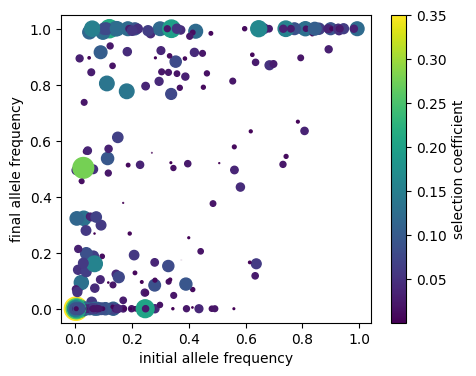

In [13]:
fig, ax1 = plt.subplots(figsize=(5, 4))
dp = ax1.scatter(p[:, 1], p[:,0], c=s, s=s*800, label='frequencies')
ax1.set_xlabel("initial allele frequency")
ax1.set_ylabel("final allele frequency")
fig.colorbar(dp, ax=ax1, label='selection coefficient');

Unsurprisingly, mutations that had a large change in allele frequency seem
to be biased towards ones with higher selection coefficients,
and those that were initially present at moderate frequency but were lost
are biased towards smaller selection coefficients.


## Add neutral mutations

In real data, of course, we don't get to observe selection coefficients.
We haven't added in neutral mutations until this point for efficiency -
they are just bookkeeping, and do not affect the course of the simulation
in any way. For this reason, we can add them in after the fact, in a way
that is exactly equivalent to having kept track of them as we went along.

Recall that out of an overall mutation rate of 3e-8,
we wanted 99% of the mutations to be neutral on the ends of the chromosome,
and 99.9% to be neutral in the middle.
So, we'll now add mutations at these rates,
using the same model of mutation as before.
The code is nearly the same as before,
with a few changes.
We've changed the ``type`` of the mutations
(so that neutral mutations will show up in SLiM as m1,
while selected mutations above were m2),
and we've asked these mutations to have SLiM mutation IDs
beginning at the ID where the previous mutations left off.
(This would be important were we to read this tree sequence
back in to SLiM; mutation IDs must be unique.)
And, importantly, we've added ``keep=True`` so that existing mutations
are not discarded.

In [14]:
neutral_mut_map = msprime.RateMap(
           position=breaks,
           rate=[2.97e-8, 2.997e-8, 2.97e-8])
next_id = pyslim.next_slim_mutation_id(ts)
neutral_mut_model = msprime.SLiMMutationModel(
                                type=1,
                                next_id=next_id)
mts = msprime.sim_mutations(
                ts,
                rate=neutral_mut_map,
                model=neutral_mut_model,
                keep=True, 
                random_seed=35)
print(f"The tree sequence now has {mts.num_mutations} mutations,")
print(f"at {mts.num_sites} distinct sites.")

The tree sequence now has 91218 mutations,
at 90757 distinct sites.


We've now got a lot more mutations!
And, we've got a lot more sites with multiple mutations:

In [15]:
num_alleles = np.array([len(s.mutations) for s in mts.sites()])
for k in range(1, max(num_alleles)+1):
  print(f"There are {sum(num_alleles == k)} sites with {k} distinct alleles.")

There are 90297 sites with 1 distinct alleles.
There are 459 sites with 2 distinct alleles.
There are 1 sites with 3 distinct alleles.


To get a nice a picture of what's happened,
we'll pull out a tree that had a lot of mutations on it,
and print a picture of it, with mutations labeled by their type:

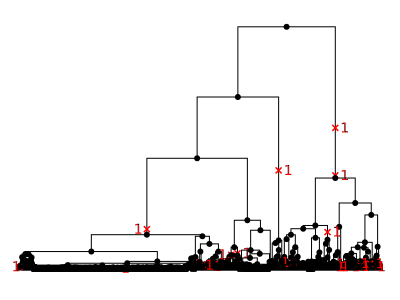

In [16]:
for t in mts.trees():
 mt = [max([u['mutation_type'] for u in m.metadata['mutation_list']]) for m in t.mutations()]
 if t.num_mutations > 12:
   break

ml = {m.id: str(mtype) for mtype, m in zip(mt, t.mutations())}
SVG(
    t.draw_svg(mutation_labels=ml,
               node_labels={},
               size=(400, 300))
)

On this tree each mutation is marked by a red "x", and labeled with its mutation type:
either "1", for newly added mutations, or "2", for selected mutations present during the SLiM portion.
(Note: this is a large tree, with 68,211 nodes!
But as usual, the main structure is visible
because most nodes coalesce very recently.)

OK, but how exactly is this working?
Can a neutral mutation be added to a site that previously had a selected mutation?
The short answer is: yes, and new alleles stack on top of
existing alleles, but existing alleles replace new alleles.
This is equivalent to including them as the simulation went along,
by the additivity property of Poisson mutations:
it turns out that the following two ways of generating mutations along the genome
are equivalent: either
(a) placing a random Poisson number with mean {math}`\mu`,
and randomly choosing each one to be non-neutral with probability 0.01, or
(b) placing random, independent Poisson numbers of neutral and non-neutral mutations
with means {math}`0.99\mu` and {math}`0.01\mu` respectively.
Since the neutral ones don't affect the simulation otherwise,
we can add them in afterwards.
Now, when the mutation algorithm in msprime puts down a new mutation
at a site with mutations already existing,
it appends the newly generated SLiM mutation ID to the previous derived state,
and adds the metadata for the new SLiM mutation to the list of metadata
from the previous mutation.
However, it doesn't modify any existing mutations,
so their derived states (and metadata) are unchanged.
The result is that, from the point of view of SLiM,
neutral ("m1") mutations "stack" on top of any other mutations (neutral or selected),
while selected ("m2") mutations stack with each other, but replace any neutral mutations.
This "stacking policy" is not actually exactly implementable in SLiM,
but given that our newly added mutations are meant to be entirely neutral,
seems like a reasonable policy.
If you wanted some other arrangement (e.g., to have m1 stack on top of m2),
you could go through and modify derived states and metadata appropriately.

Let's check there are any sites with stacked mutations of different types in the simulation.
There is indeed one such site:

In [17]:
for site in mts.sites():
  if len(site.mutations) > 1:
     types = [set([md["mutation_type"] for md in mut.metadata["mutation_list"]])
              for mut in site.mutations]
     if max(map(len, types)) > 1:
        print(site)

Site(id=11755, position=1163202.0, ancestral_state='', mutations=[Mutation(id=11823, site=11755, node=55331, derived_state='115', parent=-1, metadata={'mutation_list': [{'mutation_type': 2, 'selection_coeff': 0.05027877911925316, 'subpopulation': -1, 'slim_time': -27938, 'nucleotide': -1}]}, time=28038.93833283228, edge=340518), Mutation(id=11824, site=11755, node=19240, derived_state='115,12687', parent=11823, metadata={'mutation_list': [{'mutation_type': 2, 'selection_coeff': 0.05027877911925316, 'subpopulation': -1, 'slim_time': -27938, 'nucleotide': -1}, {'mutation_type': 1, 'selection_coeff': 0.0, 'subpopulation': -1, 'slim_time': -599, 'nucleotide': -1}]}, time=600.933737340145, edge=151458)], metadata=b'')


In [18]:
for site in mts.sites():
  if len(site.mutations) > 1:
     types = [set([md["mutation_type"] for md in mut.metadata["mutation_list"]])
              for mut in site.mutations]
     if max(map(len, types)) > 1:
        util.pp(site)

Site(id=11755, position=1163202.0, ancestral_state='', mutations=[Mutation(id=11823, site=11755, node=55331, derived_state='115', parent=-1, metadata={
    'mutation_list': [{
        'mutation_type': 2,
        'selection_coeff': 0.05027877911925316,
        'subpopulation': -1,
        'slim_time': -27938,
        'nucleotide': -1
       }]
   },
time=28038.93833283228, edge=340518), Mutation(id=11824, site=11755, node=19240, derived_state='115,12687', parent=11823, metadata={
    'mutation_list': [{
        'mutation_type': 2,
        'selection_coeff': 0.05027877911925316,
        'subpopulation': -1,
        'slim_time': -27938,
        'nucleotide': -1
       },
    {
     'mutation_type': 1,
     'selection_coeff': 0.0,
     'subpopulation': -1,
     'slim_time': -599,
     'nucleotide': -1
    }]
   },
time=600.933737340145, edge=151458)], metadata=b'')


Here, a neutral mutation has been put down on top of a selected mutation,
but stacked, so that any samples inheriting either of these mutations carries
the selected mutation.
For more discussion of how this works, see {class}`msprime.SLiMMutationModel`.


## Diversity along the genome

Now that we've correctly added neutral mutations to the tree sequence,
and lengthily digested what exactly happened,
let's have a look at the result.
To do this, we'll compute two standard measures of genetic diversity
in windows along the genome:
nucleotide diverstiy (also called "Tajima's {math}`\pi`" or "mean density of pairwise differences"),
and Tajima's {math}`D` (with no known aliases).
This is easy to do thanks to the (statistics methods in tskit)[https://tskit.dev/tskit/docs/stable/stats.html].

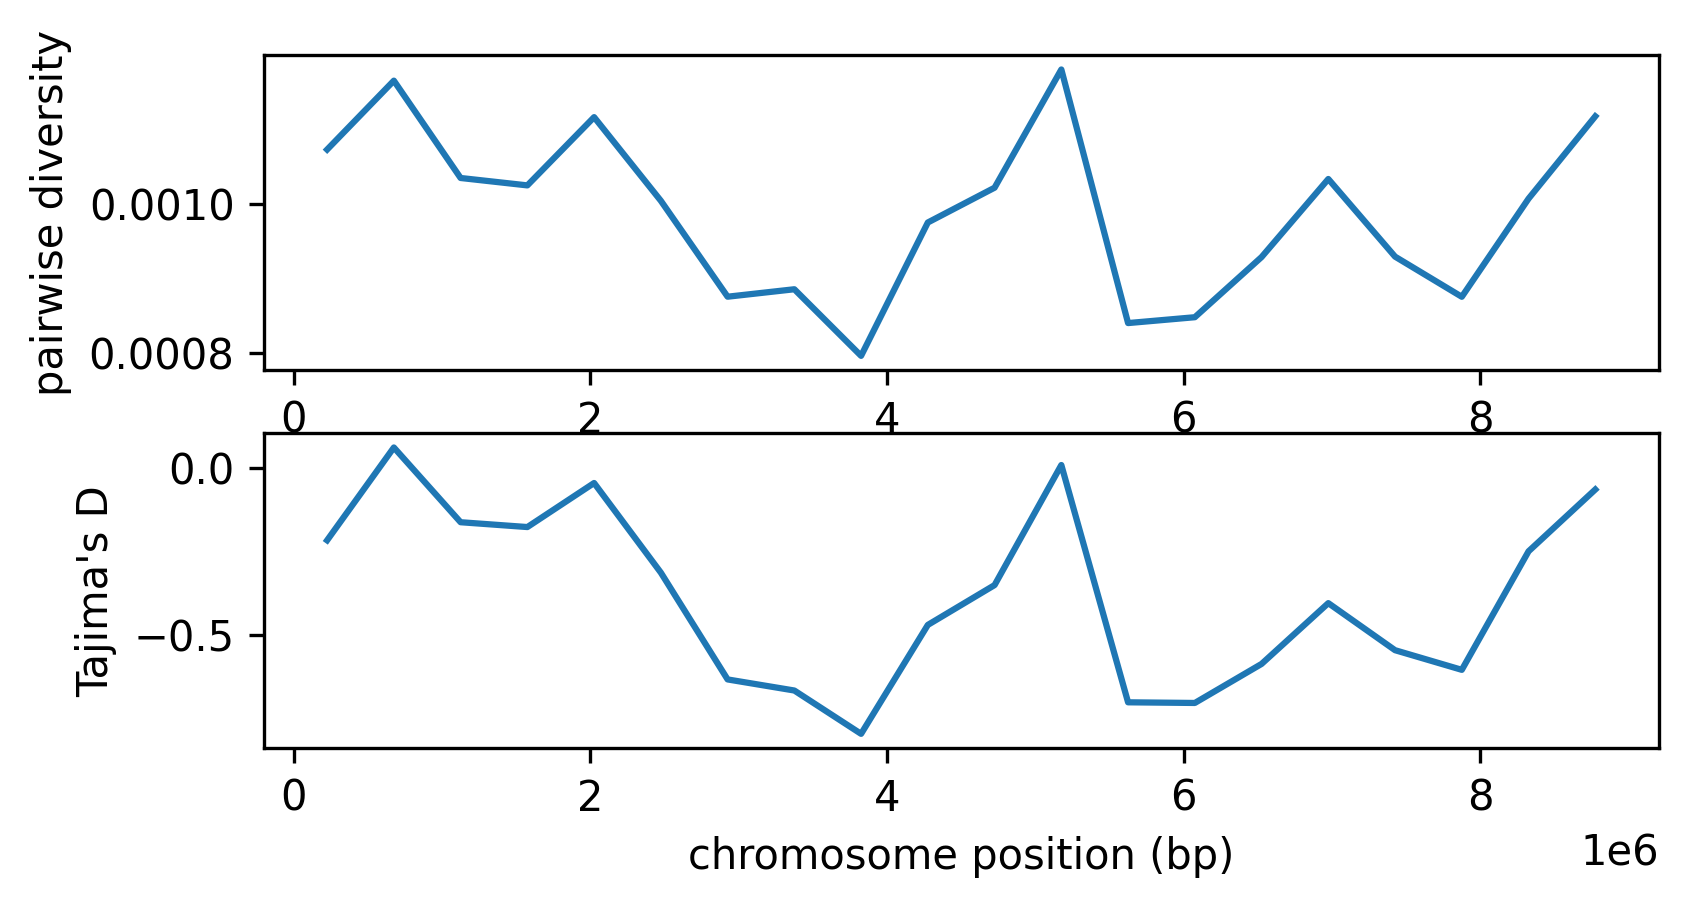

In [19]:
windows = np.linspace(0, mts.sequence_length, 21)
pi = mts.diversity(mts.samples(), windows=windows)
taj_d = mts.Tajimas_D(mts.samples(), windows=windows)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3), dpi=300)
mids = windows[1:] - np.diff(windows)/2
ax1.set_xlabel("chromosome position (bp)")
ax1.set_ylabel("pairwise diversity")
ax1.plot(mids, pi, label="pairwise diversity")
ax2.set_xlabel("chromosome position (bp)")
ax2.set_ylabel("Tajima's D")
ax2.plot(mids, taj_d, label="Tajima's D");

The two statistics are very similar - perhaps unsurprisingly, because Tajima's D is calculated using
pairwise diversity, and we have a very large sample size (here, the entire population).
Tajima's D is negative across the entire genome, as the result of selection.
However, we don't see a strong difference between the three regions,
despite the stronger action of linked selection on the ends.